# Querying Structured Data

This notebook shows you how to build an agent that can answer questions based on structured data.
We take a CSV file, load it into a SQL-Lite database and then answer questions.
Of course, if you have a database, run the SQL on it directly.

## Set up.

Install the necessary packages, set up the API keys etc.

In [1]:
#%pip install --quiet -r requirements.txt

In [1]:
from dotenv import load_dotenv
load_dotenv("../keys.env");

PROVIDER = "Google"
#PROVIDER = "OpenAI"

if PROVIDER == "Google":
    from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.1)
else:
    from langchain_openai import ChatOpenAI, OpenAIEmbeddings
    model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.1)

## Download data about popular baby names

Download names data from the US Social Security administration and extract it to a CSV file

In [2]:
import zipfile, io, os

def concatenate_text_from_zip(zip_filename, output_filename):
    with zipfile.ZipFile(zip_filename, 'r') as zip_file:
        text_files = [name for name in zip_file.namelist() if name.endswith('.txt')]  # Identify text files
        with open(output_filename, 'w', encoding='utf-8') as output_file:
            output_file.write("name,gender,count,year\n")
            for filename in text_files:
                yob = filename.replace('yob','').replace('.txt','') # yob1979.txt -> 1979
                with zip_file.open(filename, 'r') as file:
                    for line in io.TextIOWrapper(file, 'utf-8'):
                        line = f"{line.strip()},{yob}\n"
                        output_file.write(line)

if os.path.isfile('names_all_years.csv'):
    print("using already downloaded names_all_years.csv")
else:
    !wget --quiet https://www.ssa.gov/oact/babynames/names.zip                        
    concatenate_text_from_zip("names.zip", "names_all_years.csv")

using already downloaded names_all_years.csv


In [3]:
!head names_all_years.csv

name,gender,count,year
Mary,F,7065,1880
Anna,F,2604,1880
Emma,F,2003,1880
Elizabeth,F,1939,1880
Minnie,F,1746,1880
Margaret,F,1578,1880
Ida,F,1472,1880
Alice,F,1414,1880
Bertha,F,1320,1880


## Load the data into a SQL Lite database

This way, we can use SQL on the data.

In [4]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine
import pandas as pd

df = pd.read_csv("names_all_years.csv")
df.head()

,name,gender,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [5]:
engine = create_engine("sqlite:///names.db")
df.to_sql("names", engine, index=False, if_exists='replace')

2117219

Example of querying the data.  Let's find names in 1999 given to more than 20k babies.

In [6]:
db = SQLDatabase(engine=engine)
print(db.run("SELECT name, gender, count FROM names WHERE count > 20000 AND year == 1999;"))

[('Emily', 'F', 26541), ('Hannah', 'F', 21679), ('Jacob', 'M', 35370), ('Michael', 'M', 33913), ('Matthew', 'M', 30418), ('Joshua', 'M', 27261), ('Nicholas', 'M', 25639), ('Christopher', 'M', 25605), ('Andrew', 'M', 23864), ('Joseph', 'M', 23218), ('Daniel', 'M', 22704), ('Tyler', 'M', 22667), ('Brandon', 'M', 21602), ('Ryan', 'M', 21013), ('Austin', 'M', 20767), ('William', 'M', 20716), ('John', 'M', 20365), ('David', 'M', 20352)]


## Natural language to SQL

In [7]:
from langchain_community.agent_toolkits import create_sql_agent

agent_executor = create_sql_agent(model, db=db, agent_type="tool-calling", verbose=True)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'default' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [8]:
agent_executor.invoke({"input": "what was the most popular name for girls in 1999?"})



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{'tool_input': ''}`


names
Invoking: `sql_db_schema` with `{'table_names': 'names'}`



CREATE TABLE names (
	name TEXT, 
	gender TEXT, 
	count BIGINT, 
	year BIGINT
)

/*
3 rows from names table:
name	gender	count	year
Mary	F	7065	1880
Anna	F	2604	1880
Emma	F	2003	1880
*/
Invoking: `sql_db_query_checker` with `{'query': 'SELECT name FROM names WHERE year == 1999 AND gender == "F" ORDER BY count DESC LIMIT 1'}`


```sqlite
SELECT name FROM names WHERE year = 1999 AND gender = 'F' ORDER BY count DESC LIMIT 1
```
Invoking: `sql_db_query` with `{'query': 'SELECT name FROM names WHERE year == 1999 AND gender == \\"F\\" ORDER BY count DESC LIMIT 1'}`


Error: (sqlite3.OperationalError) unrecognized token: "\"
[SQL: SELECT name FROM names WHERE year == 1999 AND gender == \"F\" ORDER BY count DESC LIMIT 1]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Invoking: `sql_db_query_checker` with `{'que

{'input': 'what was the most popular name for girls in 1999?',
 'output': 'The most popular name for girls in 1999 was Emily.'}

## Fixing logic errors


In [9]:
agent_executor.invoke({"input": "what was the most popular male name in the 1950s?"})



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{'tool_input': ''}`


names
Invoking: `sql_db_schema` with `{'table_names': 'names'}`



CREATE TABLE names (
	name TEXT, 
	gender TEXT, 
	count BIGINT, 
	year BIGINT
)

/*
3 rows from names table:
name	gender	count	year
Mary	F	7065	1880
Anna	F	2604	1880
Emma	F	2003	1880
*/
Invoking: `sql_db_query_checker` with `{'query': 'SELECT name FROM names WHERE year BETWEEN 1950 AND 1959 AND gender = "M" ORDER BY count DESC LIMIT 1'}`


```sql
SELECT name FROM names WHERE year BETWEEN 1950 AND 1959 AND gender = 'M' ORDER BY count DESC LIMIT 1
```
Invoking: `sql_db_query` with `{'query': 'SELECT name FROM names WHERE year BETWEEN 1950 AND 1959 AND gender = \\"M\\" ORDER BY count DESC LIMIT 1'}`


Error: (sqlite3.OperationalError) unrecognized token: "\"
[SQL: SELECT name FROM names WHERE year BETWEEN 1950 AND 1959 AND gender = \"M\" ORDER BY count DESC LIMIT 1]
(Background on this error at: https://sqlalche.me/e/20

{'input': 'what was the most popular male name in the 1950s?',
 'output': 'The most popular male name in the 1950s was Michael. \n'}

This is wrong. The generated SQL query returns the most popular name in any single year whereas we want to the most popular name oer the entire time period. This is because the name of the column "count" is quite ambigous. Let's see how we can fix it ...

### Fix by adding a schema description

In [10]:
print(db.get_context()['table_info'])


CREATE TABLE names (
	name TEXT, 
	gender TEXT, 
	count BIGINT, 
	year BIGINT
)

/*
3 rows from names table:
name	gender	count	year
Mary	F	7065	1880
Anna	F	2604	1880
Emma	F	2003	1880
*/


In [11]:
df.head()

,name,gender,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [21]:
import sqlalchemy
from langchain_community.utilities import SQLDatabase

metadata = sqlalchemy.MetaData()
name_table = sqlalchemy.Table(
    'names', metadata,
    sqlalchemy.Column('name', sqlalchemy.String(32), nullable=False, comment='first name of baby'),
    sqlalchemy.Column('gender', sqlalchemy.String(1), nullable=False, comment='gender of baby: male (M) or female (F)'),
    sqlalchemy.Column('year', sqlalchemy.Integer, nullable=False, comment='year of birth'),
    sqlalchemy.Column('num_babies_with_name_in_year', sqlalchemy.Integer, nullable=False, comment='Number of babies with this name and gender in this year')
)
engine = sqlalchemy.create_engine("sqlite:///names.db")
name_table.drop(engine, checkfirst=False)
metadata.create_all(engine)
df2 = df.rename(columns={'count': 'num_babies_with_name_in_year'})
df2.to_sql("names", engine, index=False, if_exists='append')
db = SQLDatabase(engine=engine)
print(db.get_context()['table_info'])


CREATE TABLE names (
	name VARCHAR(32) NOT NULL, 
	gender VARCHAR(1) NOT NULL, 
	year INTEGER NOT NULL, 
	num_babies_with_name_in_year INTEGER NOT NULL
)

/*
3 rows from names table:
name	gender	year	num_babies_with_name_in_year
Mary	F	1880	7065
Anna	F	1880	2604
Emma	F	1880	2003
*/


In [22]:
print(db.run("SELECT COUNT(*) from NAMES;"))

[(2117219,)]


In [24]:
agent_executor = create_sql_agent(model, db=db, agent_type="tool-calling", verbose=True)
agent_executor.invoke(input={"input": "what was the most popular male name in the 1950s?"})

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'default' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{'tool_input': ''}`


names
Invoking: `sql_db_schema` with `{'table_names': 'names'}`



CREATE TABLE names (
	name VARCHAR(32) NOT NULL, 
	gender VARCHAR(1) NOT NULL, 
	year INTEGER NOT NULL, 
	num_babies_with_name_in_year INTEGER NOT NULL
)

/*
3 rows from names table:
name	gender	year	num_babies_with_name_in_year
Mary	F	1880	7065
Anna	F	1880	2604
Emma	F	1880	2003
*/
Invoking: `sql_db_query` with `{'query': 'SELECT name FROM names WHERE year BETWEEN 1950 AND 1959 AND gender = "M" ORDER BY num_babies_with_name_in_year DESC LIMIT 1'}`


[('Michael',)]The most popular male name in the 1950s was Michael. 


> Finished chain.


{'input': 'what was the most popular male name in the 1950s?',
 'output': 'The most popular male name in the 1950s was Michael. \n'}

doesn't help ...

## Few shot prompting

In [27]:
import sqlalchemy
from langchain_community.utilities import SQLDatabase

engine = sqlalchemy.create_engine("sqlite:///names.db")
df.to_sql("names", engine, index=False, if_exists='replace')
db = SQLDatabase(engine=engine)
print(db.get_context()['table_info'])


CREATE TABLE names (
	name TEXT, 
	gender TEXT, 
	count BIGINT, 
	year BIGINT
)

/*
3 rows from names table:
name	gender	count	year
Mary	F	7065	1880
Anna	F	2604	1880
Emma	F	2003	1880
*/


In [44]:
examples = [
    {
        "input": "how many babies named Michael were born in 1970?",
        "query": "SELECT count FROM names WHERE name = 'Michael'"
    },
    {
        "input": "how many babies named Michael were born between 1970 and 1973?",
        "query": "SELECT SUM(count) AS count FROM names WHERE name = 'Michael' AND year BETWEEN 1970 AND 1973"
    },
    {
        "input": "What was the most popular name in 1970?",
        "query": "SELECT name FROM names WHERE year = 1970 ORDER BY count DESC 1"
    },
    {
        "input": "What was the most popular name between 1970 and 1973?",
        "query": "WITH names_for_years AS (SELECT name, gender, SUM(count) AS count FROM names WHERE year BETWEEN 1970 AND 1973 GROUP BY name, gender) SELECT name FROM names_for_years ORDER BY count DESC 1"
    },    
]
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder

example_prompt = PromptTemplate.from_template("User input: {input}\nSQL query: {query}")
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="You are a SQLite expert. Given an input question, create a syntactically correct SQLite query to run. Unless otherwise specificed, do not return more than {top_k} rows.\n\nHere is the relevant table info: {table_info}\n\nBelow are a number of examples of questions and their corresponding SQL queries.",
    suffix="User input: {input}\nSQL query: ",
    input_variables=["input", "top_k", "table_info"],
)
full_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate(prompt=prompt),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

In [45]:
agent_executor = create_sql_agent(model, db=db, prompt=full_prompt, agent_type="tool-calling", verbose=True)
agent_executor.invoke(
    input={"input": "what was the most popular male name in the 1950s?"},
    
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'default' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': 'WITH names_for_years AS (SELECT name, gender, SUM(count) AS count FROM names WHERE year BETWEEN 1950 AND 1959 GROUP BY name, gender) SELECT name FROM names_for_years WHERE gender = "M" ORDER BY count DESC LIMIT 1'}`


[('James',)]The most popular male name in the 1950s was James. 


> Finished chain.


{'input': 'what was the most popular male name in the 1950s?',
 'output': 'The most popular male name in the 1950s was James. \n'}

## Graphing

In [92]:
popularity = agent_executor.invoke(
    input={"input": "Get data on number of babies with the name 'Anna' by year as a list of year, count"},  top_k=1000, max_iterations=2
)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': "SELECT year, SUM(count) AS count FROM names WHERE name = \\'Anna\\' GROUP BY year"}`


Error: (sqlite3.OperationalError) unrecognized token: "\"
[SQL: SELECT year, SUM(count) AS count FROM names WHERE name = \'Anna\' GROUP BY year]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Invoking: `sql_db_query` with `{'query': "SELECT year, SUM(count) AS count FROM names WHERE name = \\'Anna\\' GROUP BY year"}`


Error: (sqlite3.OperationalError) unrecognized token: "\"
[SQL: SELECT year, SUM(count) AS count FROM names WHERE name = \'Anna\' GROUP BY year]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Invoking: `sql_db_query` with `{'query': "SELECT year, SUM(count) AS count FROM names WHERE name = \\'Anna\\' GROUP BY year"}`


Error: (sqlite3.OperationalError) unrecognized token: "\"
[SQL: SELECT year, SUM(count) AS count FROM names WHERE name = \'Anna\' GROUP BY year]
(Backgroun

In [93]:
plot_code = model.invoke("Create Python code to chart this data as a line plot:\n" + popularity['output'])

In [94]:
import re

def get_text_between_triple_backticks(text):
  match = re.search(r'```python(.*?)```', text, re.DOTALL)
  if match:
    return match.group(1)
  else:
    return None
pycode = get_text_between_triple_backticks(plot_code.content)
with open('plot_code.py', 'w') as ofp:
    ofp.write(pycode)
!cat plot_code.py


import matplotlib.pyplot as plt

# Data as a dictionary
anna_names = {
    1880: 2616,
    1881: 2714,
    1882: 3143,
    1883: 3322,
    1884: 3880,
    1885: 4014,
    1886: 4298,
    1887: 4240,
    1888: 5008,
    1889: 5085,
    1890: 5253,
    1891: 5114,
    1892: 5562,
    1893: 5712,
    1894: 5585,
    1895: 5968,
    1896: 5877,
    1897: 5448,
    1898: 5804,
    1899: 5138,
    1900: 6139,
    1901: 4941,
    1902: 5304,
    1903: 5116,
    1904: 5346,
    1905: 5445,
    1906: 5515,
    1907: 5595,
    1908: 5870,
    1909: 5828,
    1910: 6457,
    1911: 6773,
    1912: 8615,
    1913: 9718,
    1914: 11905,
    1915: 15150,
    1916: 15263,
    1917: 15193,
    1918: 15697,
    1919: 14540,
    1920: 14614,
    1921: 14504,
    1922: 13449,
    1923: 12903,
    1924: 13108,
    1925: 12284,
    1926: 11746,
    1927: 11265,
    1928: 10626,
    1929: 9792,
    1930: 9132,
    1931: 8462,
    1932: 7962,
    1933: 7098,
    1934: 6704,
    1935: 6192,
    1936: 5764,
 

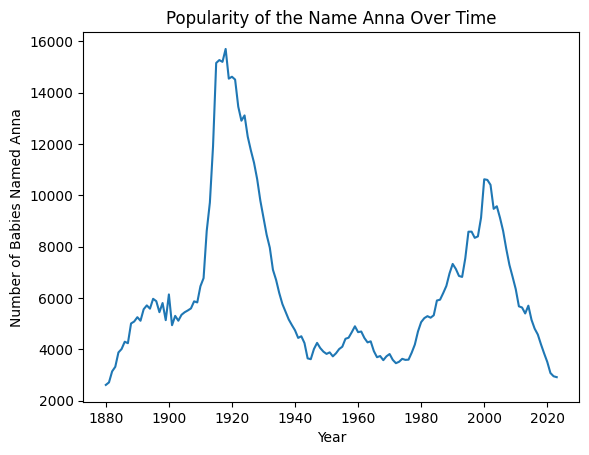

<Figure size 640x480 with 0 Axes>

In [95]:
%run plot_code.py